Ukljucivanje pocetnih biblioteka

In [1]:
#import potrebnih biblioteka
%matplotlib inline
import cv2
import collections
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt
from scipy.spatial import distance
import imutils
#import image_analysis
import threading



# k-means
from sklearn.cluster import KMeans

# keras
from keras.models import Sequential
from keras.layers.core import Dense,Activation
from keras.optimizers import SGD

import matplotlib.pylab as pylab
pylab.rcParams['figure.figsize'] = 16, 12 # za prikaz većih slika i plotova, zakomentarisati ako nije potrebno





Funkcije za obradu


In [2]:
#Funkcionalnost implementirana u V1
def load_image(path):
    return cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)
def image_gray(image):
    return cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
def image_bin(image_gs):
    ret,image_bin = cv2.threshold(image_gs, 127, 255, cv2.THRESH_BINARY)
    return image_bin
def image_bin_adaptive(image_gs):
    image_bin = cv2.adaptiveThreshold(image_gs, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 35, 10)
    return image_bin
def invert(image):
    return 255-image
def display_image(image, color= False):
    if color:
        plt.imshow(image)
    else:
        plt.imshow(image, 'gray')
def dilate(image):
    kernel = np.ones((3,3)) # strukturni element 3x3 blok
    return cv2.dilate(image, kernel, iterations=1)
def erode(image):
    kernel = np.ones((3,3)) # strukturni element 3x3 blok
    return cv2.erode(image, kernel, iterations=1)

#Funkcionalnost implementirana u V2
def resize_region(region):
    resized = cv2.resize(region,(28,28), interpolation = cv2.INTER_NEAREST)
    return resized
def scale_to_range(image):
    return image / 255
def matrix_to_vector(image):
    return image.flatten()
def prepare_for_ann(regions):
    ready_for_ann = []
    for region in regions:
        ready_for_ann.append(matrix_to_vector(scale_to_range(region)))
    return ready_for_ann
def convert_output(outputs):
    return np.eye(len(outputs))
def winner(output):
    return max(enumerate(output), key=lambda x: x[1])[0]

Izdvajanje regiona od interesa

[]


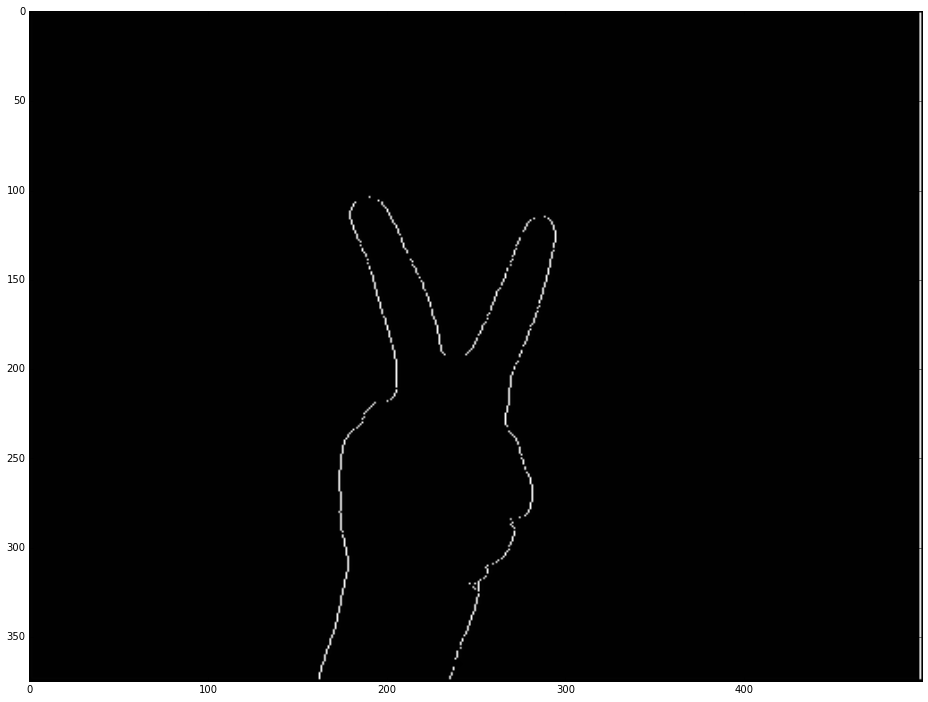

In [23]:
def select_roi(image_orig, image_bin):
    '''Oznaciti regione od interesa na originalnoj slici. (ROI = regions of interest)
        Za svaki region napraviti posebnu sliku dimenzija 28 x 28. 
        Za označavanje regiona koristiti metodu cv2.boundingRect(contour).
        Kao povratnu vrednost vratiti originalnu sliku na kojoj su obeleženi regioni
        i niz slika koje predstavljaju regione sortirane po rastućoj vrednosti x ose
    '''
    img, contours, hierarchy = cv2.findContours(image_bin.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    sorted_regions = [] # lista sortiranih regiona po x osi (sa leva na desno)
    

    cv2.drawContours(img, contours, 3, (0,255,0), 3)
    display_image(img)   
        
    regions_dic = {}
    for contour in contours: 
        x,y,w,h = cv2.boundingRect(contour) #koordinate i velicina granicnog pravougaonika
        area = cv2.contourArea(contour)
        if area > 700 and h < 180 and h > 90 and w > 20:
            # kopirati [y:y+h+1, x:x+w+1] sa binarne slike i smestiti u novu sliku
            # označiti region pravougaonikom na originalnoj slici (image_orig) sa rectangle funkcijom
            region = image_bin[y:y+h+1,x:x+w+1];
            regions_dic[x] = resize_region(region)       
            cv2.rectangle(image_orig,(x,y),(x+w,y+h),(0,255,0),2)
    
    sorted_regions_dic = collections.OrderedDict(sorted(regions_dic.items()))
    sorted_regions = sorted_regions_dic.values()
    # sortirati sve regione po x osi (sa leva na desno) i smestiti u promenljivu sorted_regions
    return image_orig, sorted_regions

image_color = load_image('capture5.jpg')
img = invert(image_bin(image_gray(image_color)))
img_bin = erode(dilate(img))
selected_regions, numbers = select_roi(image_color.copy(), img)
#display_image(selected_regions)
print numbers

Kreiranje neurnoske mreze

In [4]:
def create_ann():
    
    ann = Sequential()
    # Postavljanje slojeva neurona mreže 'ann'
    ann.add(Dense(input_dim=784, output_dim=128,init="glorot_uniform"))
    ann.add(Activation("sigmoid"))
    ann.add(Dense(input_dim=128, output_dim=1,init="glorot_uniform"))
    ann.add(Activation("sigmoid"))
    return ann

Treniranje neuronske mreze

In [5]:
def train_ann(ann, X_train, y_train):
    X_train = np.array(X_train, np.float32)
    y_train = np.array(y_train, np.float32)
   
    # definisanje parametra algoritma za obucavanje
    sgd = SGD(lr=0.01, momentum=0.9)
    ann.compile(loss='mean_squared_error', optimizer=sgd)

    # obucavanje neuronske mreze
    ann.fit(X_train, y_train, nb_epoch=500, batch_size=1, verbose = 0, shuffle=False, show_accuracy = False) 
      
    return ann

Priprema za neuronsku mrezu

In [6]:
def prepare_for_ann(regions):
    '''Regioni su matrice dimenzija 28x28 čiji su elementi vrednosti 0 ili 255.
        Potrebno je skalirati elemente regiona na [0,1] i transformisati ga u vektor od 784 elementa '''
    ready_for_ann = []
    for region in regions:
        # skalirati elemente regiona (metoda iz TODO 3 scale_to_range)
        # region sa skaliranim elementima pretvoriti u vektor (metoda iz TODO 4 matrix_to_vector)
        # vektor dodati u listu spremnih regiona
        scale = scale_to_range(region)
        ready_for_ann.append(matrix_to_vector(scale))
        
    return ready_for_ann

In [7]:
def convert_output(alphabet):
    '''Konvertovati alfabet u niz pogodan za obučavanje NM,
        odnosno niz čiji su svi elementi 0 osim elementa čiji je
        indeks jednak indeksu elementa iz alfabeta za koji formiramo niz.
        Primer prvi element iz alfabeta [1,0,0,0,0,0,0,0,0,0],
        za drugi [0,1,0,0,0,0,0,0,0,0] itd..
    '''
    nn_outputs = []
    for index in range(len(alphabet)):
        output = np.zeros(len(alphabet))
        output[index] = 1
        nn_outputs.append(output)
    return np.array(nn_outputs)

Izlaz

In [8]:
def winner(output): # output je vektor sa izlaza neuronske mreze
    '''pronaći i vratiti indeks neurona koji je najviše pobuđen'''
    return max(enumerate(output), key=lambda x: x[1])[0]

In [9]:
def display_result(outputs, alphabet):
    '''za svaki rezultat pronaći indeks pobedničkog
        regiona koji ujedno predstavlja i indeks u alfabetu.
        Dodati karakter iz alfabet u result'''
    result = []
    for output in outputs:
        result.append(alphabet[winner(output)])
    return result

Obucavanje neuronske mreze

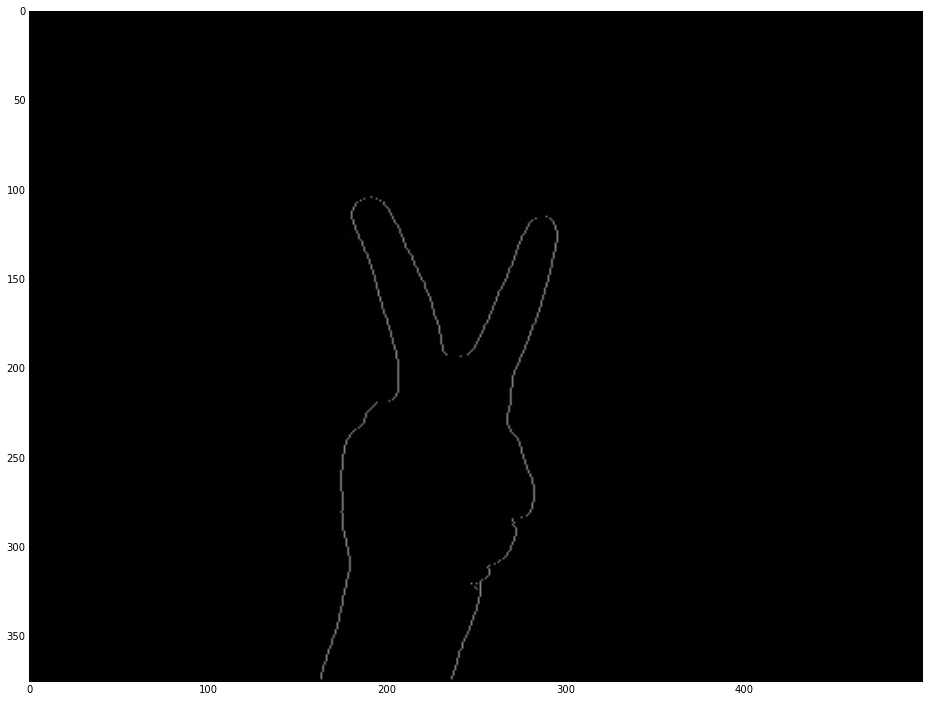

In [10]:
image_color = load_image('capture5.jpg')
img = invert(image_bin(image_gray(image_color)))
img_bin = erode(dilate(img))
selected_regions, numbers = select_roi(image_color.copy(), img)
display_image(selected_regions)
#display_image(imutils.resize(img,width = 200,height=200))

alfabet

In [11]:
alphabet = ["U"]

In [13]:
inputs = prepare_for_ann(selected_regions)
outputs = convert_output(alphabet)
ann = create_ann()
ann = train_ann(ann, inputs, outputs)

ValueError: ('shapes (1,1500) and (784,128) not aligned: 1500 (dim 1) != 784 (dim 0)', (1L, 1500L), (784L, 128L))
Apply node that caused the error: Dot22(<TensorType(float64, matrix)>, <TensorType(float64, matrix)>)
Inputs types: [TensorType(float64, matrix), TensorType(float64, matrix)]
Inputs shapes: [(1L, 1500L), (784L, 128L)]
Inputs strides: [(12000L, 8L), (1024L, 8L)]
Inputs values: ['not shown', 'not shown']

HINT: Re-running with most Theano optimization disabled could give you a back-trace of when this node was created. This can be done with by setting the Theano flag 'optimizer=fast_compile'. If that does not work, Theano optimizations can be disabled with 'optimizer=None'.
HINT: Use the Theano flag 'exception_verbosity=high' for a debugprint and storage map footprint of this apply node.

In [ ]:
#result = ann.predict(np.array(inputs[0:1], np.float32))
#print result
#print display_result(result, alphabet)

ROI

In [ ]:
lower = np.array([0,77,77], dtype = "uint8")
upper = np.array([255,223,196], dtype = "uint8")

def nothing(x):
    pass


cv2.namedWindow('image')
cv2.createTrackbar('th1','image',0,255,nothing)
cv2.createTrackbar('th2','image',0,255,nothing)


camera = cv2.VideoCapture(0)

while True:
    
    (grabbed,frame) = camera.read()
    frame = imutils.resize(frame,width = 500)
    
# sa bojom 
    converted = cv2.cvtColor(frame,cv2.COLOR_BGR2HSV)
    skinMask = cv2.inRange(converted, lower, upper)
    
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(1,1))
    skinMask = cv2.erode(skinMask, kernel,iterations = 2)
    skinMask = cv2.dilate(skinMask, kernel, iterations = 2)
    skinMask = cv2.GaussianBlur(skinMask, (3, 3), 0)
    skin = cv2.bitwise_and(frame, frame, mask = skinMask)
    
#sa ivicama
    
    th1 = cv2.getTrackbarPos('th1','image')
    th2 = cv2.getTrackbarPos('th2','image')
    edges = cv2.Canny(frame,th1,th2)
    
    cv2.imshow("image",edges)
    
    
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    gray = cv2.bilateralFilter(gray, 11, 17, 17)
    edged = cv2.Canny(gray, 40, 150)
    edged = cv2.erode(edged,kernel,iterations=2)
    edged = cv2.dilate(edged,kernel,iterations=5)
    
    contours = cv2.findContours(edged,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)[-2]
#    center = None

    
    #KRUG OKO RUKE
    if len(contours) > 0:
        c = max(contours, key=cv2.contourArea)
        ((x, y), radius) = cv2.minEnclosingCircle(c)
        rect = cv2.minAreaRect(c)
#        M = cv2.moments(c)
#        center = (int(M["m10"] / M["m00"]), int(M["m01"] / M["m00"]))
        if radius > 80:
            cv2.circle(frame, (int(x), int(y)), int(radius),(0, 255, 255), 2)
            #cv2.circle(frame, center, 5, (0, 0, 255), -1)
            #cv2.rectangle(frame,(int(rect[0][0]),int(rect[0][1])),(int(rect[1][0]),int(rect[1][1])),(0,255,0),3)

    cv2.drawContours(frame, contours, -1, (0,0,255), 2)
    

    cv2.imshow("i",edged)
    cv2.imshow("images", np.hstack([frame, skin]))
    
    
    

    
    
    if cv2.waitKey(1) & 0xFF == ord("q"):
        break
 

camera.release()
cv2.destroyAllWindows()